In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd
import seaborn as sns
import pickle
import glob
import Ressources.TransformHelper as TransformHelper

In [2]:
def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data

In [3]:
# External data for mapping 
transform_infos = load_from_disk("./Ressources/map_image_transform_infos.pickle")
transform_matrix = transform_infos["perspective_transform_matrix"]
white_bg_img = cv2.imread("./Ressources/map_white.png")
building_names_df = pd.read_csv("./Ressources/building_collider_list.csv",index_col=0)

In [71]:

def generate_building_hits_map(collider_hit_df,building_names_df,bg_img,title="Building Hits",limit_to_top_n=-1,max_hits_override=-1,min_hits_override=0,save_path=""):
    '''
    Generate a map with circles on buildings to indicate number of hits.
    @param collider_hit_df: Dataframe that holds the hitpoint data.
    @param building_names_df: Dataframe that holds the relevant building (collider) names, used to exclude unwanted colliders from the hit dataframe.
    @param title: Title of the plot.
    @param limit_to_top_n: Show only top n buildings with most hitpoints; -1 to show all.
    @param max_hits_override: Number of hits to assume as maximum value for color and size calculation of the dots; -1 to calculate from data.
    @param min_hits_override: Number of hits to assume as minimum value for color and size calculation of the dots.
    @param save_path: Save plot at this location; "" to not save.
    '''
    
    # drop all rows with colliders that are not in include_colliders
    include_colliders = list(set(list(building_names_df["target_collider_name"])))
    collider_hit_df = collider_hit_df.loc[collider_hit_df["ColliderName"].isin(include_colliders)]
    
    # groupby collider names 
    hits_count = collider_hit_df.groupby("ColliderName").sum().reset_index(drop=False).sort_values("Samples",ascending=False).reset_index(drop=True)
    hits_count["transformed_collidercenter_x"] = None
    hits_count["transformed_collidercenter_y"] = None
    
    # extract map positions
    for idx, row in hits_count.iterrows():
        transformed_x = building_names_df.loc[building_names_df["target_collider_name"] == row["ColliderName"]]["transformed_collidercenter_x"].iloc[0]
        transformed_y = building_names_df.loc[building_names_df["target_collider_name"] == row["ColliderName"]]["transformed_collidercenter_y"].iloc[0]
        hits_count.loc[hits_count.index[idx], "transformed_collidercenter_x"] = transformed_x
        hits_count.loc[hits_count.index[idx], "transformed_collidercenter_y"] = transformed_y
        
      
    # plot map 
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0, 0, 1, 1])
    plt.title(title, fontsize=20)
    plt.xlim(0, bg_img.shape[0])
    plt.ylim(0, bg_img.shape[1])
    ax.set_frame_on(False)
    plt.axis('off')
    plt.imshow(bg_img, aspect = bg_img.shape[1] / bg_img.shape[0], extent = ax.get_xlim() + ax.get_ylim(), zorder=1) 
    
    
    # colormap 
    cmap = plt.cm.get_cmap('Greens')

    # add circles to map, dynamic size between min and max size  
    min_hits = min_hits_override
    max_hits = np.ceil(max(hits_count["Samples"]) / 500) * 500
    print("Min hits: " + str(min_hits))
    print("Max hits calculated: " + str(max_hits))
    if max_hits_override > 0:
        max_hits = max_hits_override
        print("Max hits overridden: " + str(max_hits))
    
    min_circle_size = 12
    max_circle_size = 60
    circles = [] 
    for idx, row in hits_count.iterrows():  
        if limit_to_top_n > 0 and idx >= limit_to_top_n: # display only first n buildings
            break
        else:
            hit_factor = (row["Samples"] - min_hits) / (max_hits - min_hits)
            circle_size = hit_factor * (max_circle_size - min_circle_size) + min_circle_size
            circles.append(plt.Circle((row["transformed_collidercenter_x"],row["transformed_collidercenter_y"]), radius = circle_size, color = cmap(hit_factor), zorder=2))
            ax.add_artist(circles[idx])  

    # add legend 
    legend_entries = []
    number_of_entries = 5
    legend_hits = np.linspace(min_hits, max_hits, number_of_entries + 1, dtype = int)
    marker_size_rel = 0.54
    for idx in range(number_of_entries):
        hit_factor = (legend_hits[idx+1] - min_hits) / (max_hits - min_hits)
        circle_size = hit_factor * (max_circle_size - min_circle_size) + min_circle_size
        legend_entries.extend(ax.plot([], [], c=cmap(hit_factor) , marker='o', markersize=circle_size*marker_size_rel, fillstyle='full', linestyle='none'))
    ax.legend(tuple(legend_entries), (tuple([str(elem) for elem in legend_hits[1:]])), numpoints=1, labelspacing=2, loc='upper right', fontsize=16, borderpad = 1.2)
    
    # save plot 
    if save_path != "":
        plt.savefig(save_path,bbox_inches='tight')
    
# Max hits rounded up to hundreds 
# 1013 9100
# 1021 7800
# 1017 11100
# 1005 8200
# 1011 11800
# 1023 8800
# 1008 10000
# 1010 10100
    

## Exploration data

In [72]:
# Extract data paths per participant
condensed_exploration_files = glob.glob("./Results/*_interpolation_df.csv")
exploration_files_dict = {}
for idx, elem in enumerate(condensed_exploration_files):
    subject_id = elem.split("_interpolation_df.csv")[0].split("/")[-1]
    exploration_files_dict[subject_id] = condensed_exploration_files[idx]
print("Available IDs: " + str(exploration_files_dict.keys()))


Available IDs: dict_keys(['1013', '1021', '1017', '1005', '1011', '1023', '1008', '1010'])


Subject: 1013
Min hits: 0
Max hits calculated: 9500.0
Max hits overridden: 12000
Subject: 1021
Min hits: 0
Max hits calculated: 8000.0
Max hits overridden: 12000
Subject: 1017
Min hits: 0
Max hits calculated: 11500.0
Max hits overridden: 12000
Subject: 1005
Min hits: 0
Max hits calculated: 8500.0
Max hits overridden: 12000
Subject: 1011
Min hits: 0
Max hits calculated: 12000.0
Max hits overridden: 12000
Subject: 1023
Min hits: 0
Max hits calculated: 9000.0
Max hits overridden: 12000
Subject: 1008
Min hits: 0
Max hits calculated: 10000.0
Max hits overridden: 12000
Subject: 1010
Min hits: 0
Max hits calculated: 10500.0
Max hits overridden: 12000


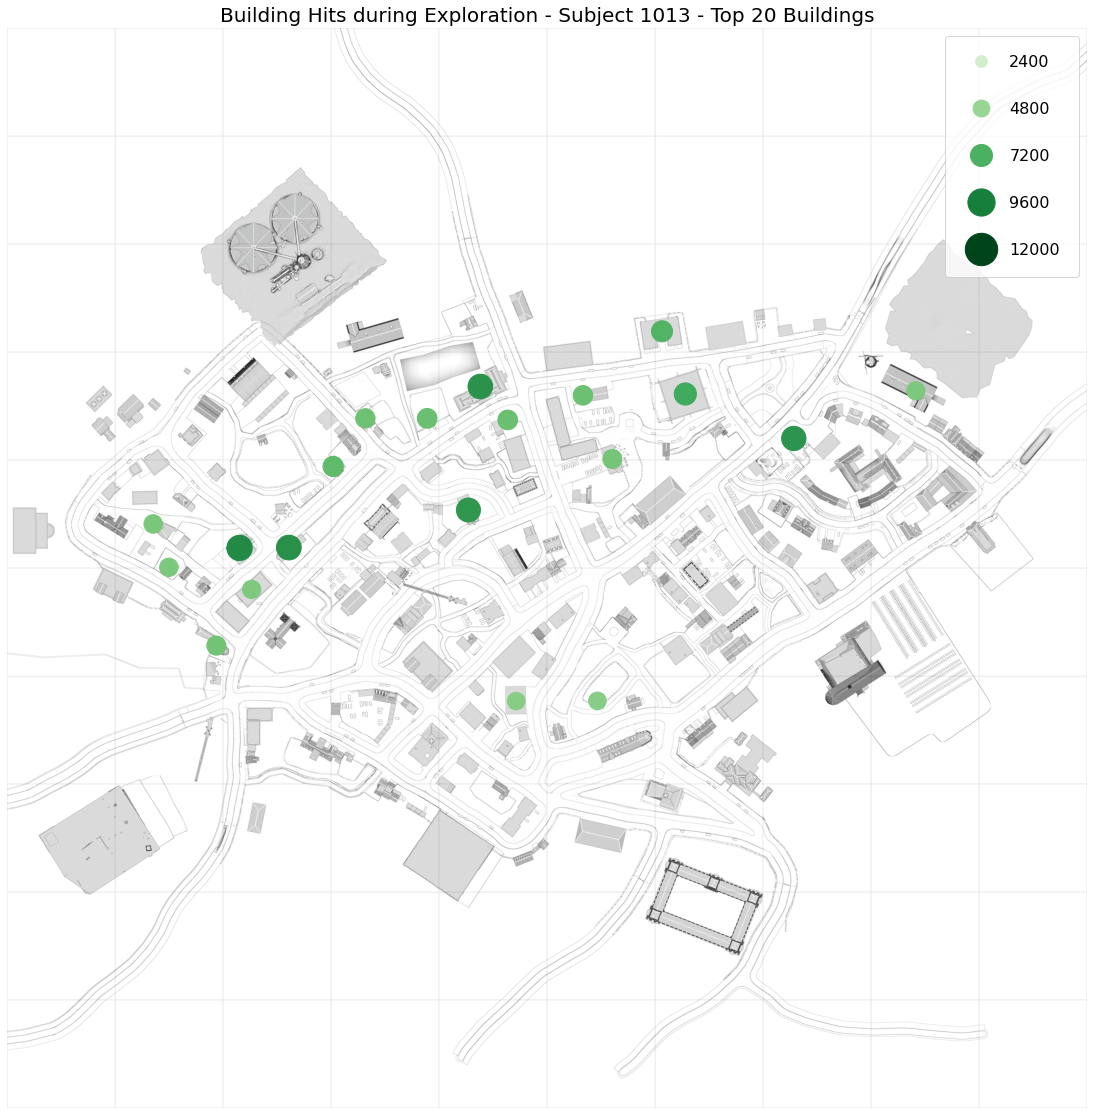

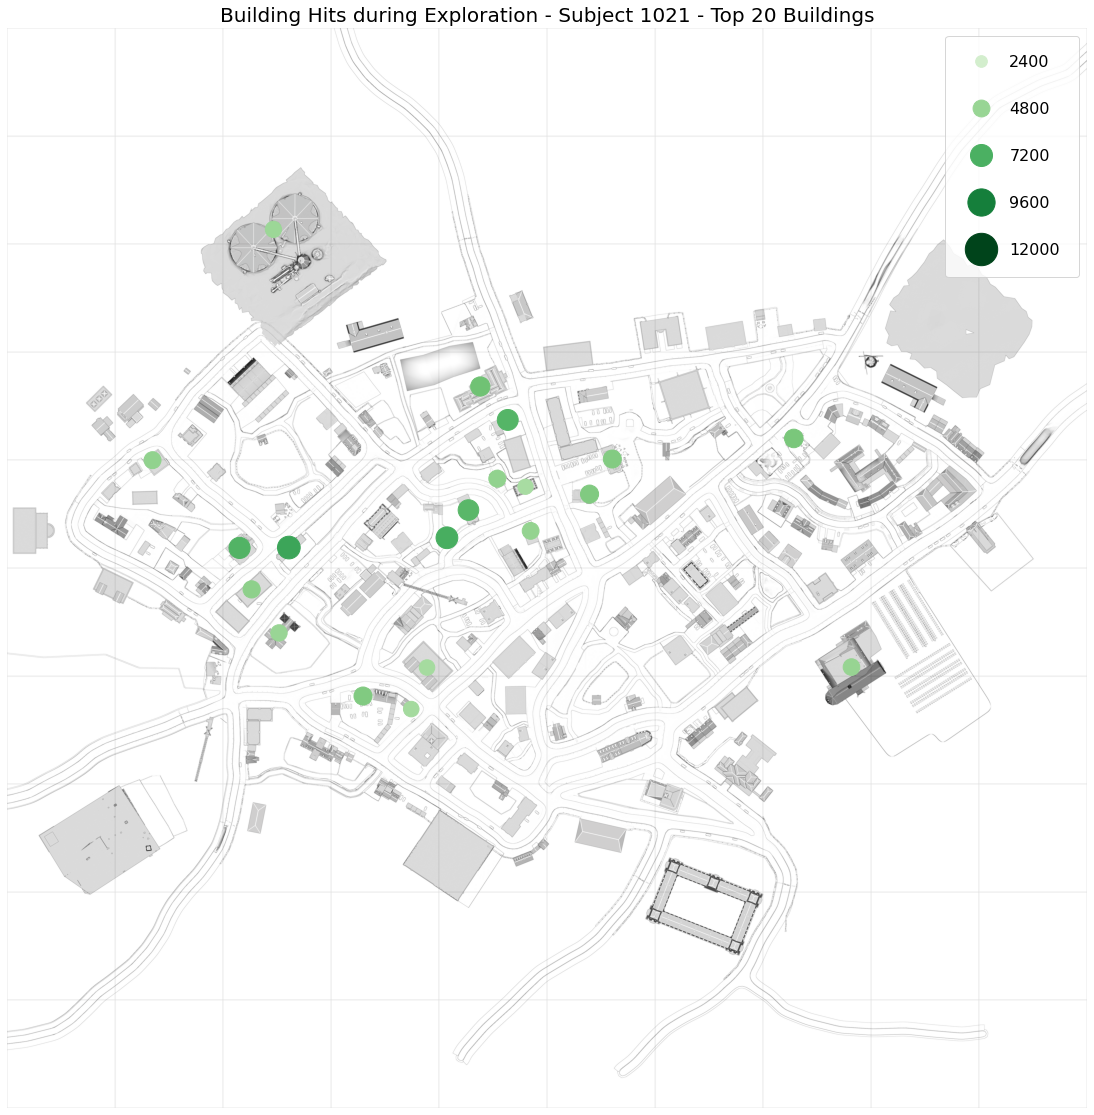

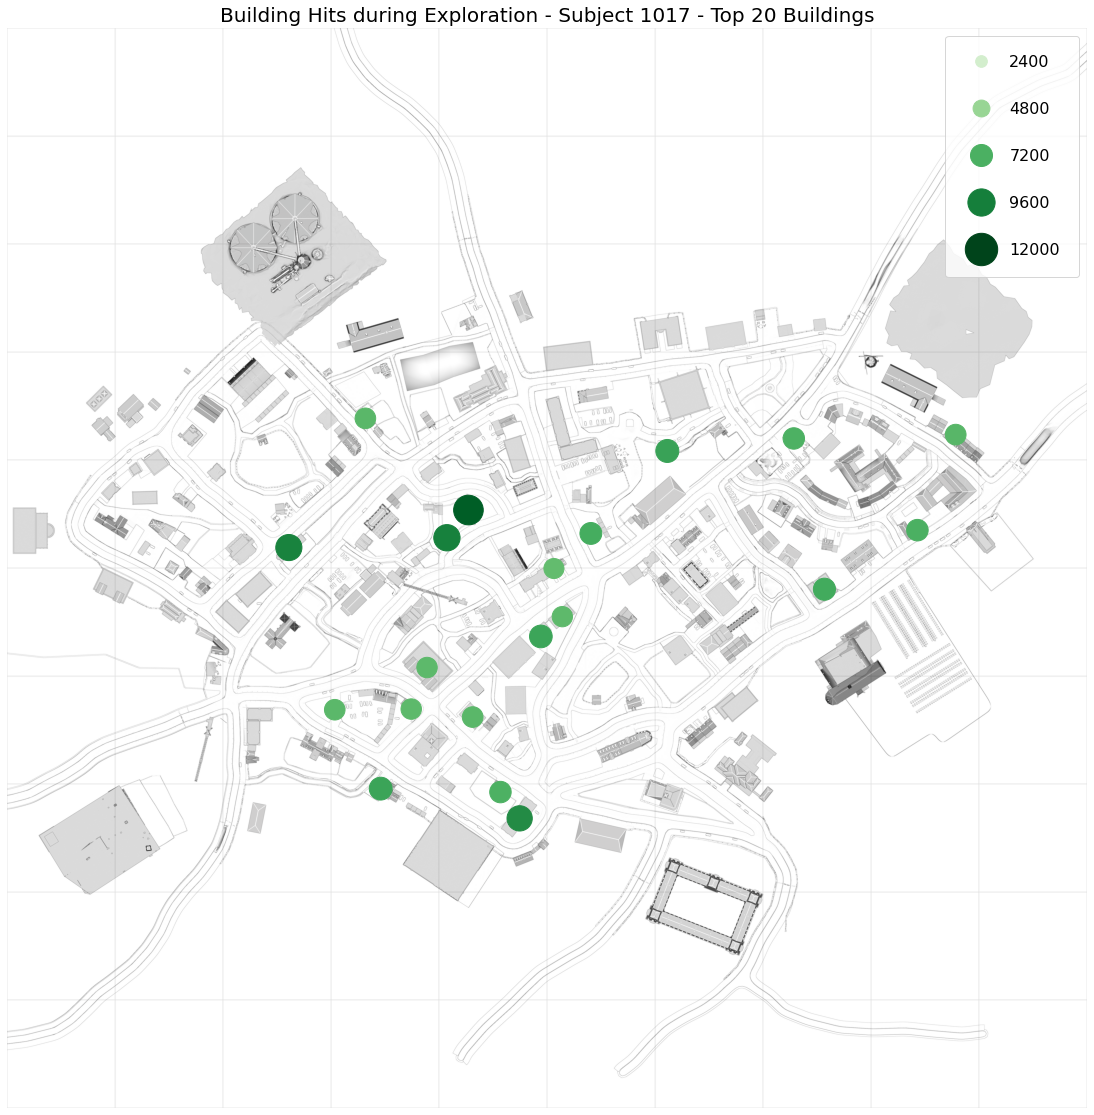

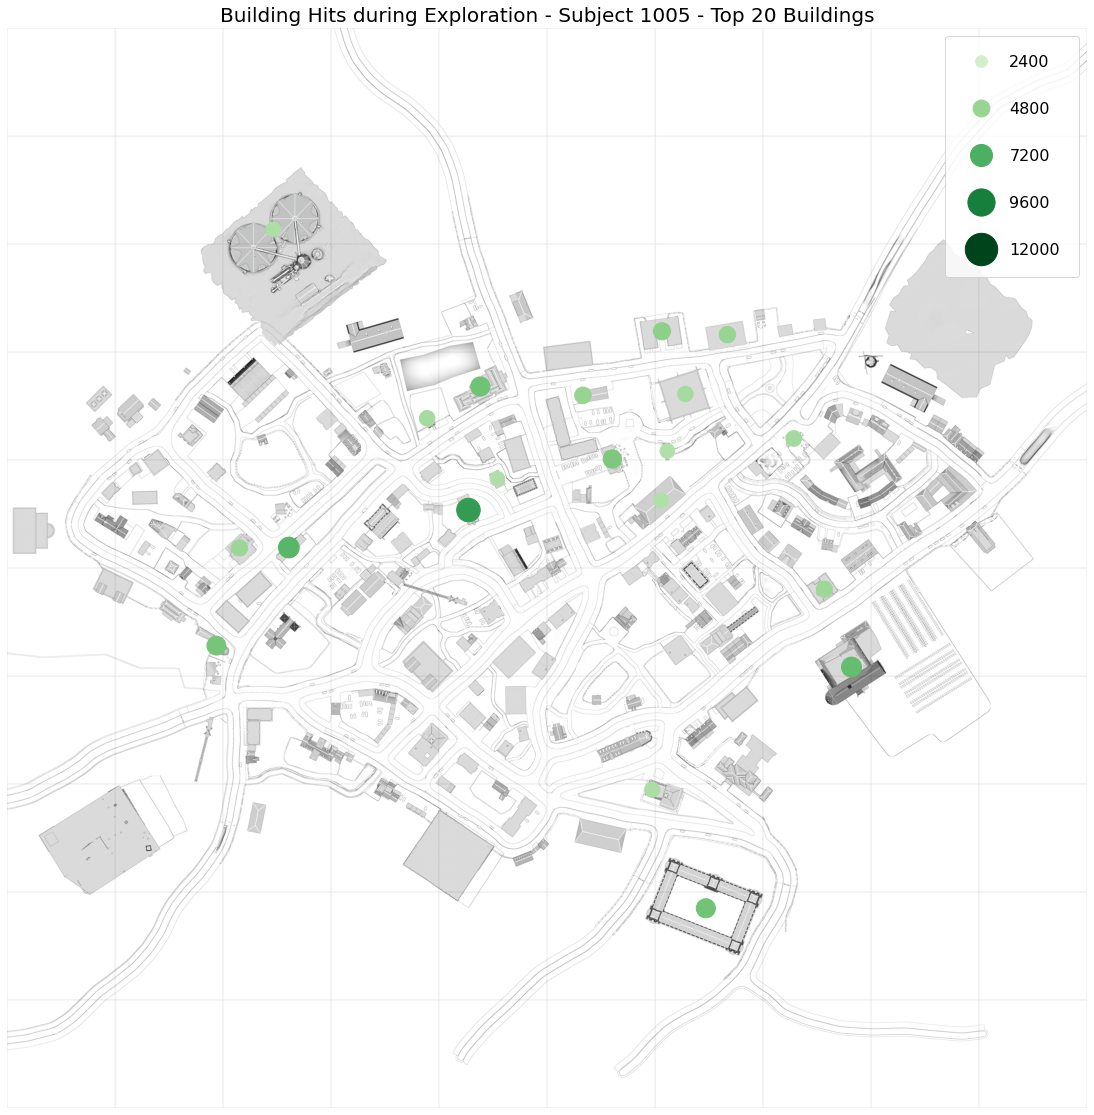

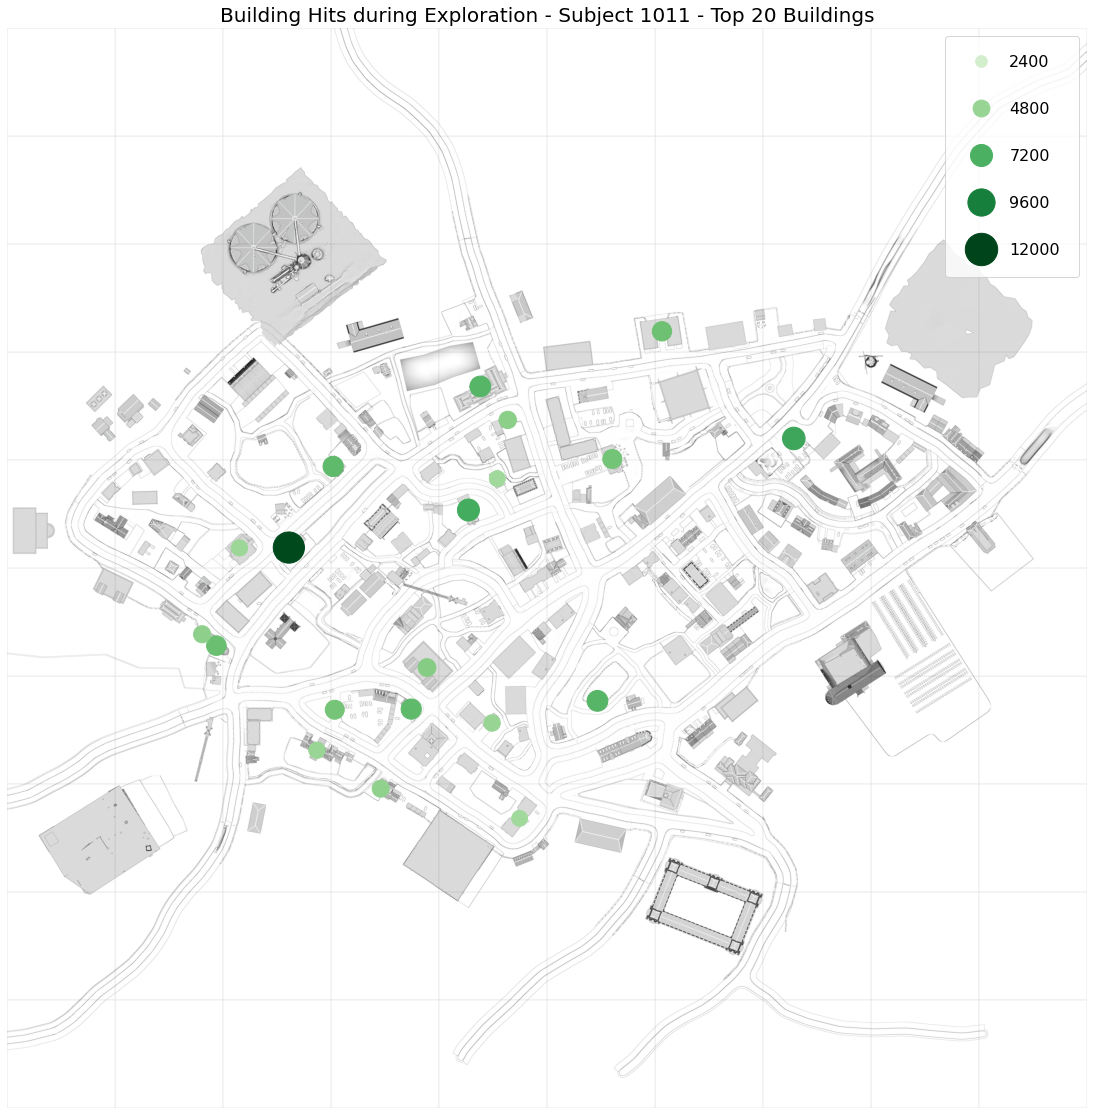

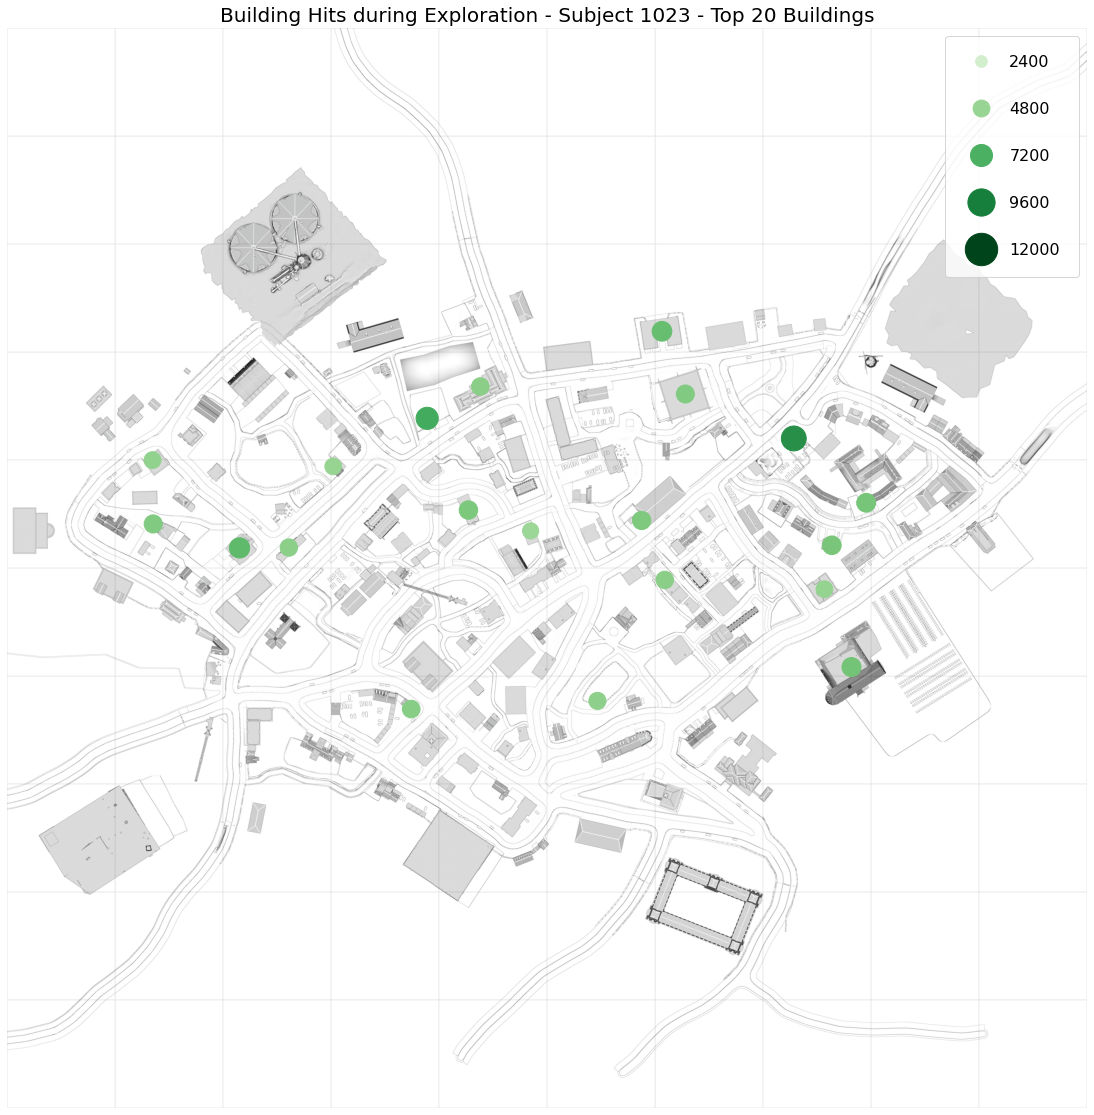

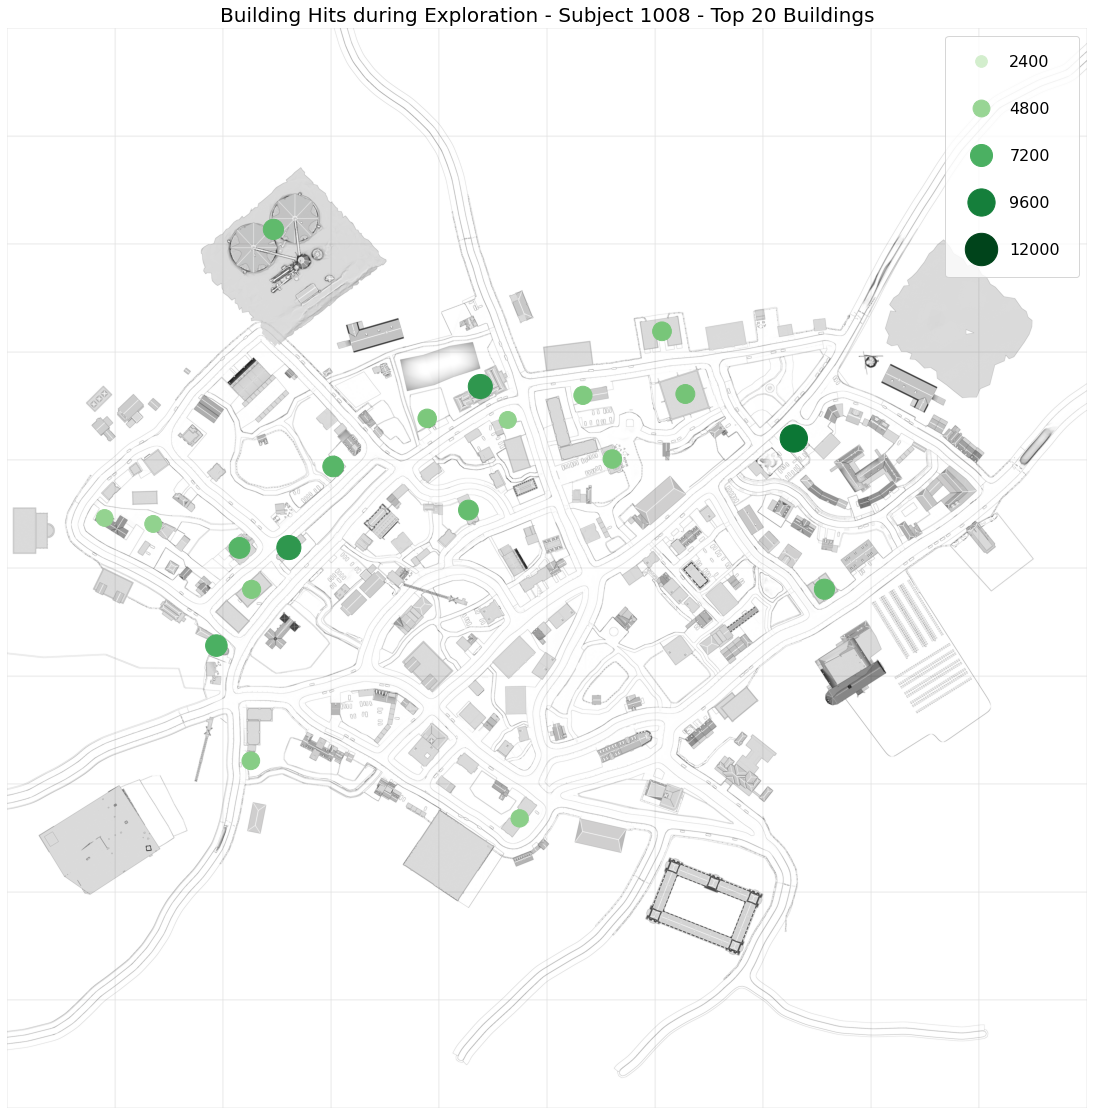

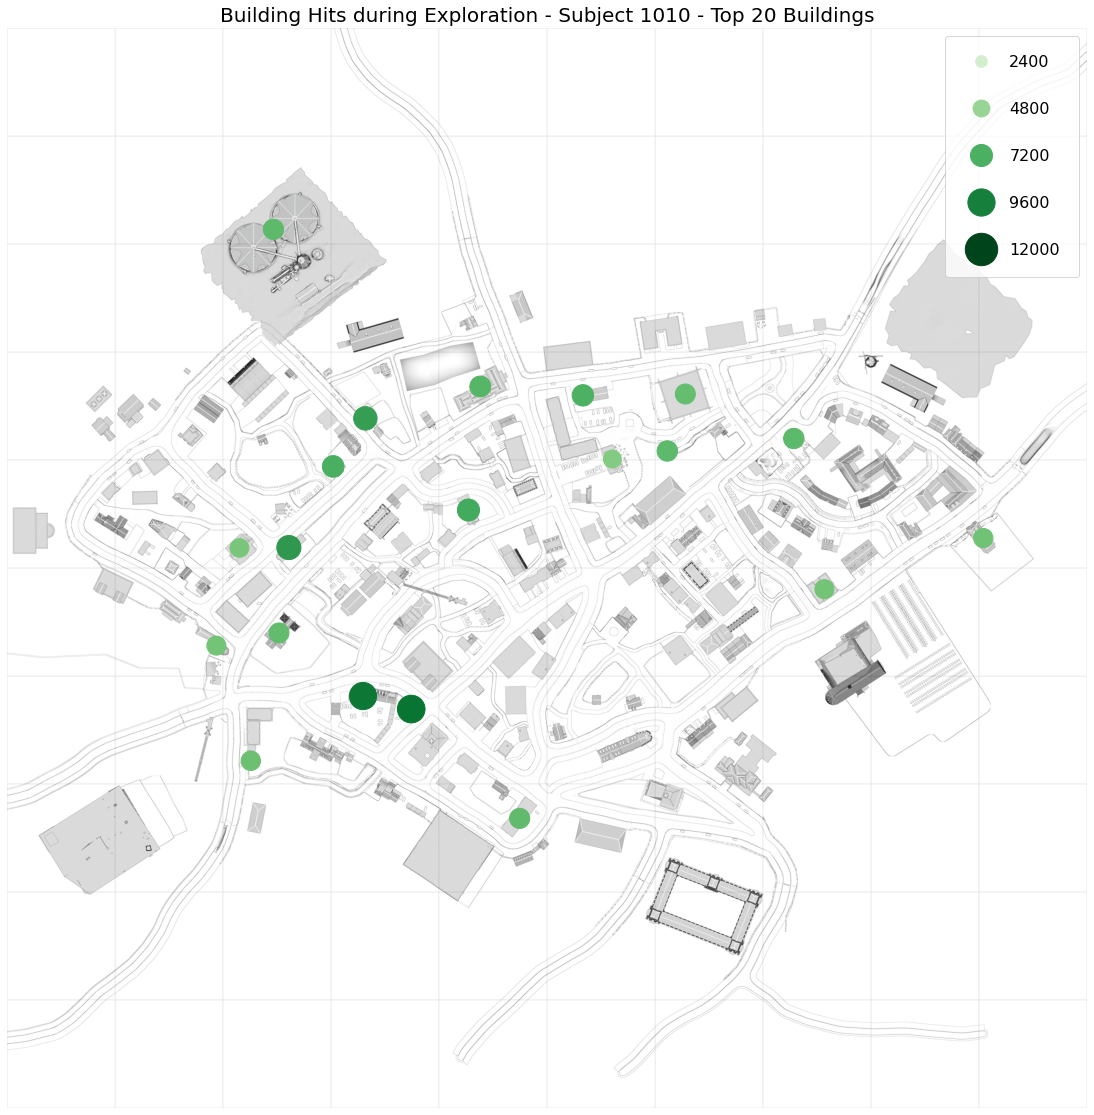

In [75]:

top_n_buildings = 20 # -1 for no filtering 

# One participant at a time 
for subject_id in exploration_files_dict.keys():
    print("Subject: " + str(subject_id))
    condensed_exploration = pd.read_csv(exploration_files_dict[subject_id],index_col=2)
    plot_title = "Building Hits during Exploration - Subject " + str(subject_id)
    save_at_path = "./Results/BuildingHits/building_hits_exploration_" + str(subject_id)
    if top_n_buildings > 0: 
        plot_title += " - Top " + str(top_n_buildings) + " Buildings"
        save_at_path += "_top" + str(top_n_buildings) 
    save_at_path += ".png"

    generate_building_hits_map(condensed_exploration,building_names_df,white_bg_img,title=plot_title,limit_to_top_n=top_n_buildings,max_hits_override=12000,min_hits_override=0,save_path=save_at_path)



Min hits: 0
Max hits calculated: 67000.0


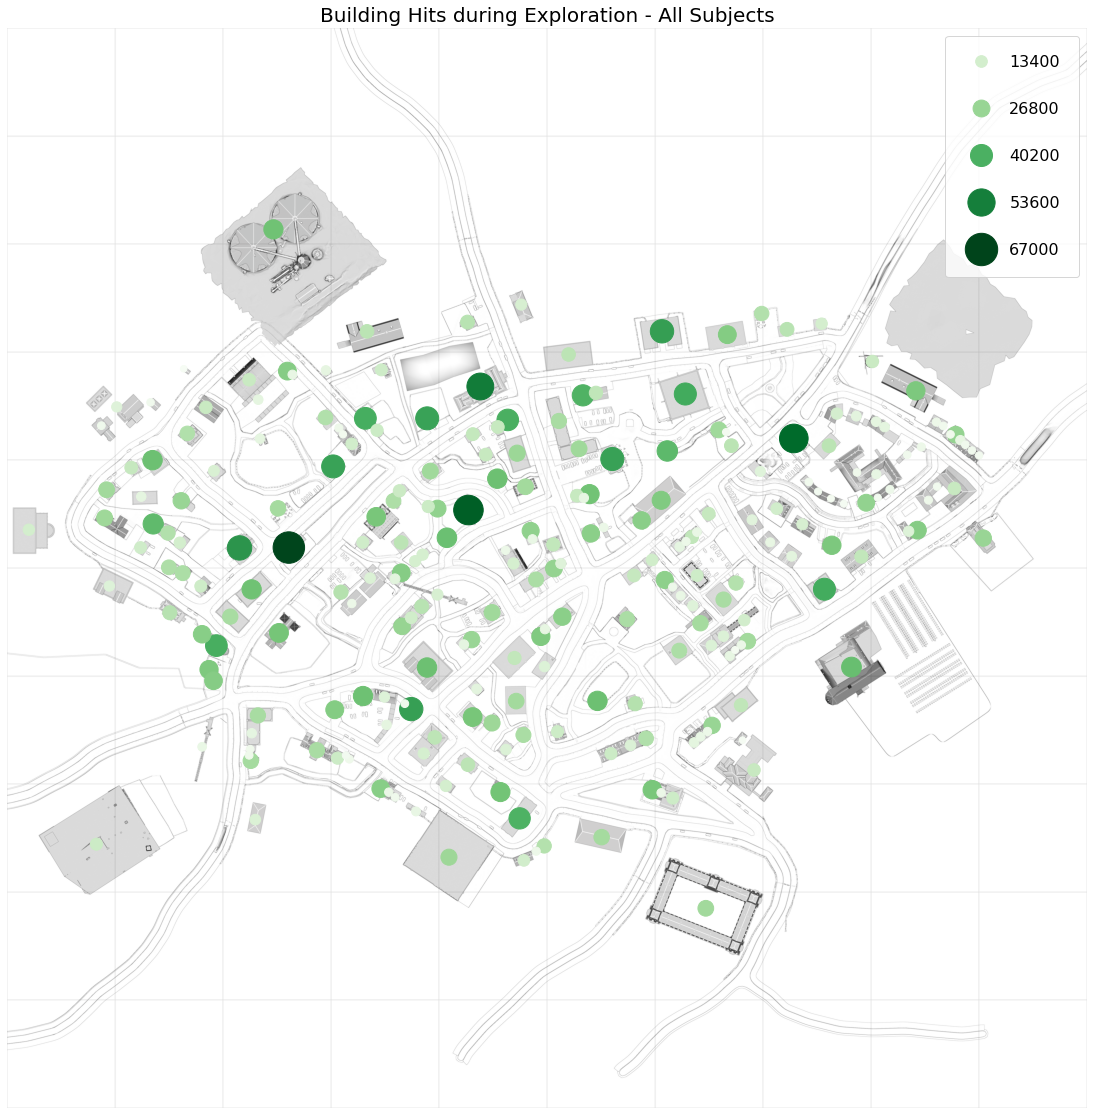

In [77]:
# All participants combined 

top_n_buildings = 20 # -1 for no filtering 
plot_title = "Building Hits during Exploration - All Subjects"
save_at_path = "./Results/BuildingHits/building_hits_exploration_all_subjects"
if top_n_buildings > 0: 
    plot_title += " - Top " + str(top_n_buildings) + " Buildings"
    save_at_path += "_top" + str(top_n_buildings) 
save_at_path += ".png"

# combine data 
combined_exploration_df = pd.DataFrame() 
for subject_id in exploration_files_dict.keys():
    if combined_exploration_df.empty:
        combined_exploration_df = pd.read_csv(exploration_files_dict[subject_id],index_col=2)
    else:
        combined_exploration_df = combined_exploration_df.append(pd.read_csv(exploration_files_dict[subject_id],index_col=2))
        pass
combined_exploration_df = combined_exploration_df.reset_index(drop=True)

# generate map 
generate_building_hits_map(combined_exploration_df,building_names_df,white_bg_img,title=plot_title,limit_to_top_n=top_n_buildings,max_hits_override=-1,min_hits_override=0,save_path=save_at_path)



# Older stuff starts below

## Measurement data exploration

In [6]:
# Read example file 
example_df = pd.read_csv("./Ressources/pre/for_collider_list_1023_CompleteExploration_Hitpoints.csv")
#example_df[:10]

In [7]:
# Apply pixel transformation for collider centers & hit points  
example_df = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),dataframe=example_df,df_x_name="hitObjectColliderBoundsCenter.x",df_y_name="hitObjectColliderBoundsCenter.z",transform_x_name="transformed_collidercenter_x",transform_y_name="transformed_collidercenter_y")
example_df = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),dataframe=example_df,df_x_name="hitPointOnObject.x",df_y_name="hitPointOnObject.z",transform_x_name="transformed_hitpoint_x",transform_y_name="transformed_hitpoint_y")

example_df[:10]

Calculating Perspective Transform for DataFrame...


100%|██████████| 377285/377285 [00:40<00:00, 9369.62it/s] 


Calculating Perspective Transform for DataFrame...


100%|██████████| 377285/377285 [00:39<00:00, 9535.65it/s] 


Unnamed: 0  timeStampDataPointStart  timeStampDataPointEnd  \
0           0             1.619691e+09           1.619691e+09   
1           1             1.619691e+09           1.619691e+09   
2           0             1.619691e+09           1.619691e+09   
3           1             1.619691e+09           1.619691e+09   
4           0             1.619691e+09           1.619691e+09   
5           1             1.619691e+09           1.619691e+09   
6           0             1.619691e+09           1.619691e+09   
7           0             1.619691e+09           1.619691e+09   
8           0             1.619691e+09           1.619691e+09   
9           1             1.619691e+09           1.619691e+09   

   hitObjectColliderName  ordinalOfHit  hitPointOnObject.x  \
0         pavement_O.002             1          -64.191063   
1          terrain_S.001             2          -65.567734   
2         pavement_O.002             1          -64.191063   
3          terrain_S.001             2          -65.567734   
4         pavement_O.002             1          -64.027878   
5  road_base_network.004             2          -65.057053   
6          terrain_S.001             1          -65.711441   
7          terrain_S.001             1          -66.227020   
8         pavement_O.002             1          -63.692066   
9  road_base_network.004             2          -64.704819   

   hitPointOnObject.y  hitPointOnObject.z  hitObjectColliderBoundsCenter.x  \
0            1.429070           71.214470                      -165.163147   
1            1.163447           81.047607                       -60.390293   
2            1.429070           71.214470                      -165.163147   
3            1.163447           81.047607                       -60.390293   
4            1.426832           70.591492                      -165.163147   
5            1.221172           78.057304                        39.257874   
6            1.185995           83.164772                       -60.390293   
7            1.206157           87.327980                       -60.390293   
8            1.419669           68.122917                      -165.163147   
9            1.200827           75.465088                        39.257874   

   hitObjectColliderBoundsCenter.y  hitObjectColliderBoundsCenter.z  \
0                         1.451688                       -15.555870   
1                         1.153675                       100.804741   
2                         1.451688                       -15.555870   
3                         1.153675                       100.804741   
4                         1.451688                       -15.555870   
5                        -4.408301                        51.768860   
6                         1.153675                       100.804741   
7                         1.153675                       100.804741   
8                         1.451688                       -15.555870   
9                        -4.408301                        51.768860   

   transformed_collidercenter_x  transformed_collidercenter_y  \
0                   1367.184847                   1983.633874   
1                   1799.187626                   2463.431630   
2                   1367.184847                   1983.633874   
3                   1799.187626                   2463.431630   
4                   1367.184847                   1983.633874   
5                   2210.625643                   2260.284238   
6                   1799.187626                   2463.431630   
7                   1799.187626                   2463.431630   
8                   1367.184847                   1983.633874   
9                   2210.625643                   2260.284238   

   transformed_hitpoint_x  transformed_hitpoint_y  
0             1783.685774             2341.266386  
1             1777.935818             2381.879862  
2             1783.685774             2341.266386  
3             1777.935818             2

<AxesSubplot:xlabel='transformed_hitpoint_x', ylabel='Count'>

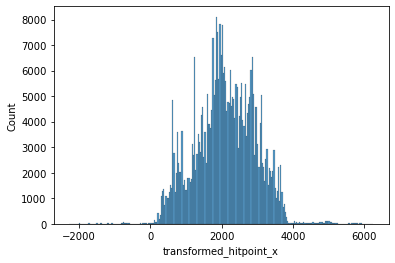

In [8]:

sns.histplot(example_df["transformed_hitpoint_x"])

In [9]:
only_first_ordinal = example_df.loc[example_df["ordinalOfHit"] == 1]
only_first_ordinal[:10]

Unnamed: 0  timeStampDataPointStart  timeStampDataPointEnd  \
0            0             1.619691e+09           1.619691e+09   
2            0             1.619691e+09           1.619691e+09   
4            0             1.619691e+09           1.619691e+09   
6            0             1.619691e+09           1.619691e+09   
7            0             1.619691e+09           1.619691e+09   
8            0             1.619691e+09           1.619691e+09   
10           0             1.619691e+09           1.619691e+09   
12           0             1.619691e+09           1.619691e+09   
14           0             1.619691e+09           1.619691e+09   
16           0             1.619691e+09           1.619691e+09   

   hitObjectColliderName  ordinalOfHit  hitPointOnObject.x  \
0         pavement_O.002             1          -64.191063   
2         pavement_O.002             1          -64.191063   
4         pavement_O.002             1          -64.027878   
6          terrain_S.001             1          -65.711441   
7          terrain_S.001             1          -66.227020   
8         pavement_O.002             1          -63.692066   
10        pavement_O.002             1          -63.761074   
12        pavement_O.002             1          -63.761074   
14          Building_160             1          -72.201660   
16          Building_160             1          -72.201660   

    hitPointOnObject.y  hitPointOnObject.z  hitObjectColliderBoundsCenter.x  \
0             1.429070           71.214470                      -165.163147   
2             1.429070           71.214470                      -165.163147   
4             1.426832           70.591492                      -165.163147   
6             1.185995           83.164772                       -60.390293   
7             1.206157           87.327980                       -60.390293   
8             1.419669           68.122917                      -165.163147   
10            1.422320           69.136017                      -165.163147   
12            1.422320           69.136017                      -165.163147   
14            2.897408          116.358757                       -68.428040   
16            2.897408          116.358757                       -68.428040   

    hitObjectColliderBoundsCenter.y  hitObjectColliderBoundsCenter.z  \
0                          1.451688                       -15.555870   
2                          1.451688                       -15.555870   
4                          1.451688                       -15.555870   
6                          1.153675                       100.804741   
7                          1.153675                       100.804741   
8                          1.451688                       -15.555870   
10                         1.451688                       -15.555870   
12                         1.451688                       -15.555870   
14                         4.519094                       122.944267   
16                         4.519094                       122.944267   

    transformed_collidercenter_x  transformed_collidercenter_y  \
0                    1367.184847                   1983.633874   
2                    1367.184847                   1983.633874   
4                    1367.184847                   1983.633874   
6                    1799.187626                   2463.431630   
7                    1799.187626                   2463.431630   
8                    1367.184847                   1983.633874   
10                   1367.184847                   1983.633874   
12                   1367.184847                   1983.633874   
14                   1765.843387                   2554.953670   
16                   1765.843387                   2554.953670   

    transformed_hitpoint_x  transformed_hitpoint_y  
0              1783.685774             2341.266386  
2              1783.685774             2341.266386  
4              1784.363730             2338.6

# Plotting

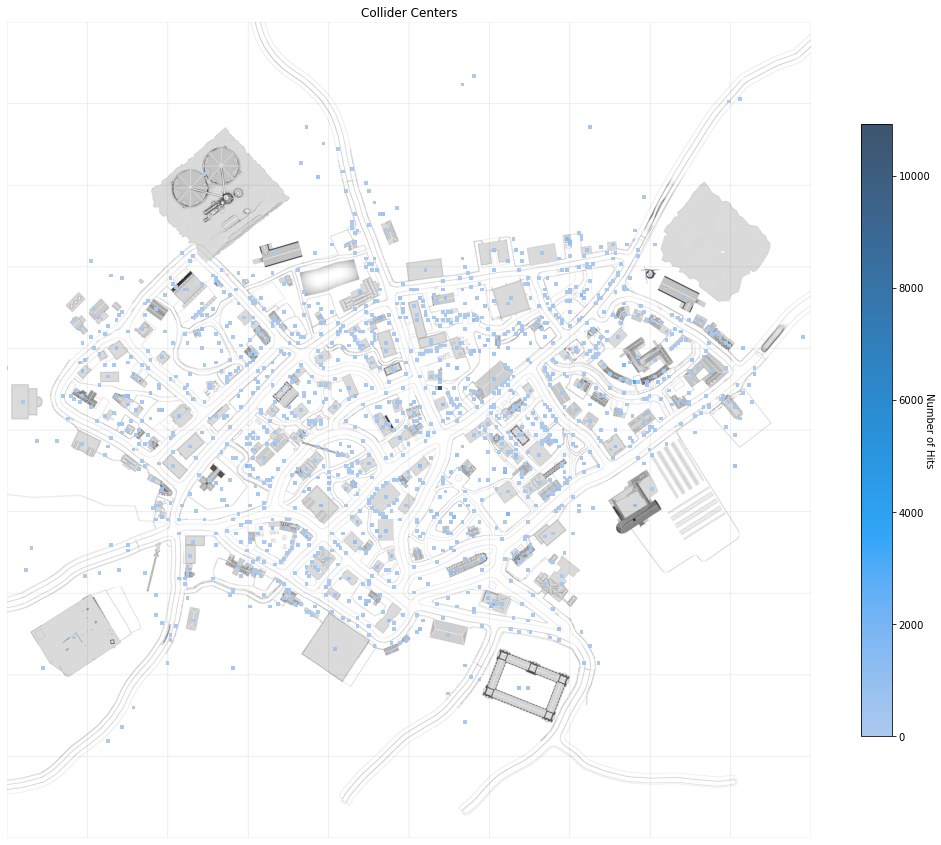

In [12]:
# Hit collider centers

fig, ax = plt.subplots(figsize=(18, 15))

map_bins = 400
histplot = sns.histplot(only_first_ordinal,x="transformed_collidercenter_x",y="transformed_collidercenter_y",bins=map_bins,discrete=(False,False),log_scale=(False,False), cbar=True, cbar_kws={"shrink":0.75}, zorder=2, ax=ax) #alpha = 1,
ax.collections[0].colorbar.set_label("Number of Hits",rotation=270) # fontsize, labelpad

ax.set_frame_on(False)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
plt.title("Collider Centers")
plt.axis('off')
#plt.show()

# add background map 
histplot.imshow(white_bg_img,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

plt.show()



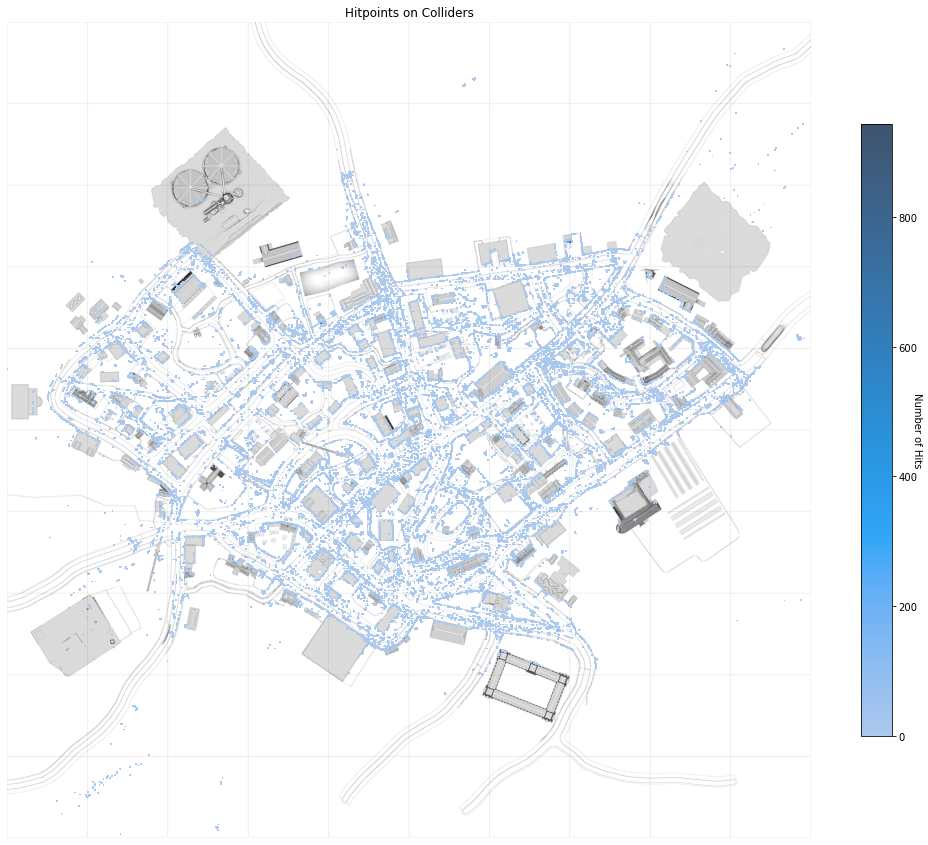

In [13]:
# Hit points on colliders

fig, ax = plt.subplots(figsize=(18, 15))

map_bins = 2048
histplot = sns.histplot(only_first_ordinal,x="transformed_hitpoint_x",y="transformed_hitpoint_y",bins=map_bins,discrete=(False,False),log_scale=(False,False), cbar=True, cbar_kws=dict(shrink=0.75), alpha = 1, zorder=2, ax=ax)
ax.collections[0].colorbar.set_label("Number of Hits",rotation=270) # fontsize, labelpad


ax.set_frame_on(False)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
plt.title("Hitpoints on Colliders")
plt.axis('off')


# add background map 
histplot.imshow(white_bg_img,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

plt.show() # add



### House hits

In [19]:
# example_df 
#"hitPointOnObject.x",df_y_name="hitPointOnObject.z",transform_x_name="transformed_hitpoint_x",transform_y_name="transformed_hitpoint_y"

# load house list 
building_names_df = pd.read_csv("./Ressources/building_collider_list.csv")

only_first_ordinal[:1]
building_names_df



Unnamed: 0       source_collider_name       target_collider_name  \
0             0               Building_100               Building_100   
1             1               Building_101               Building_101   
2             2               Building_102               Building_102   
3             3               Building_103               Building_103   
4             4               Building_104               Building_104   
..          ...                        ...                        ...   
249         249                    crane_1                    crane_1   
250         250                    crane_2                    crane_2   
251         251               Building_191               Building_191   
252         252     Church-TaskBuilding_16     Church-TaskBuilding_16   
253         253  Building_combined_115_116  Building_combined_115_116   

     ColliderBoundsCenter.x  ColliderBoundsCenter.y  ColliderBoundsCenter.z  \
0                 27.202402                4.637518               66.574875   
1                 29.179993                9.017884              109.739998   
2                 10.699999                9.022681              135.199997   
3                 44.767456                6.790395              161.120209   
4                148.502731                5.281566               50.124672   
..                      ...                     ...                     ...   
249             -101.114072               19.279706              -24.529291   
250             -317.305069               25.279850             -164.529755   
251             -363.551361                3.137159              151.427521   
252              280.184875               19.870625              -90.926231   
253              181.197006                2.886840              -47.747000   

     transformed_collidercenter_x  transformed_collidercenter_y  
0                     2160.852245                   2321.450565  
1                     2168.810296                   2499.573289  
2                     2092.451899                   2604.853246  
3                     2232.877085                   2711.561031  
4                     2660.648524                   2252.769625  
..                            ...                           ...  
249                   1631.882345                   1946.305511  
250                    739.380449                   1369.138826  
251                    543.725122                   2675.546576  
252                   3202.008624                   1671.525322  
253                   2795.310638                   1849.466877  

[254 rows x 8 columns]

In [ ]:
# TODO: Rename colliders from source to target 

In [20]:
# find number of hits on houses; groupby building name and collider center, get rid of non-house colliders
sorted_by_collider = only_first_ordinal.groupby(["hitObjectColliderName","hitObjectColliderBoundsCenter.x","hitObjectColliderBoundsCenter.y","hitObjectColliderBoundsCenter.z"]).count()
sorted_by_collider.reset_index(inplace=True)
sorted_by_collider = sorted_by_collider[sorted_by_collider["hitObjectColliderName"].isin(building_names_df["target_collider_name"])]
sorted_by_collider.reset_index(inplace=True)
sorted_by_collider.to_csv("./test.csv")
print("Houses with multiple different colliders:")
building_cnt = sorted_by_collider.groupby("hitObjectColliderName").count()
print(building_cnt.loc[building_cnt["hitObjectColliderBoundsCenter.x"] != 1]["hitObjectColliderBoundsCenter.x"])
print()

# apply perspective transformation to collider positions and rename
sorted_by_collider.drop(columns=["transformed_collidercenter_x","transformed_collidercenter_y","transformed_hitpoint_x","transformed_hitpoint_y","timeStampDataPointStart","timeStampDataPointEnd","ordinalOfHit","hitPointOnObject.y","hitPointOnObject.z"],inplace=True)
sorted_by_collider = sorted_by_collider.loc[:, ~sorted_by_collider.columns.str.contains('^Unnamed')]
sorted_by_collider = sorted_by_collider.rename(columns={"hitPointOnObject.x":"hit_points"})
sorted_by_collider = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),dataframe=sorted_by_collider,df_x_name="hitObjectColliderBoundsCenter.x",df_y_name="hitObjectColliderBoundsCenter.z",transform_x_name="transformed_collidercenter_x",transform_y_name="transformed_collidercenter_y")

# sort by number of hits
sorted_by_collider.sort_values("hit_points",ascending=False,inplace=True)
sorted_by_collider


Houses with multiple different colliders:
hitObjectColliderName
Building_174    2
Building_183    2
Building_192    2
Building_193    2
Building_205    2
Garage_185      5
Garage_224      3
Garage_235      7
Garage_86       4
Garage_98       4
crane_1         3
Name: hitObjectColliderBoundsCenter.x, dtype: int64

Calculating Perspective Transform for DataFrame...


100%|██████████| 263/263 [00:00<00:00, 4433.56it/s]


index hitObjectColliderName  hitObjectColliderBoundsCenter.x  \
232   1289       TaskBuilding_34                       -36.325558   
216   1273        TaskBuilding_2                       197.372269   
243   1300       TaskBuilding_44                      -125.418945   
207   1264        TaskBuilding_1                       255.196808   
43     226          Building_145                        13.617243   
..     ...                   ...                              ...   
77     260          Building_179                      -203.048508   
195    929            Garage_235                      -142.503006   
92     275          Building_193                      -405.550934   
260   1488               crane_1                      -113.048508   
175    358           Building_95                       164.476242   

     hitObjectColliderBoundsCenter.y  hitObjectColliderBoundsCenter.z  \
232                         7.075362                       136.050385   
216                        -0.791097                       234.411163   
243                         5.564157                      -129.803604   
207                         4.129490                       -19.178940   
43                          4.364902                       -44.695030   
..                               ...                              ...   
77                          3.997824                       181.162918   
195                         0.293124                      -128.057709   
92                          3.790440                       122.972923   
260                         8.412663                       -20.889994   
175                         4.502962                       125.316757   

     hit_points  transformed_collidercenter_x  transformed_collidercenter_y  
232        1552                   1898.341573                   2608.803715  
216        1374                   2861.554685                   3012.459198  
243        1284                   1532.328936                   1512.219745  
207        1086                   3099.436622                   1966.741610  
43         1027                   2105.369757                   1862.671507  
..          ...                           ...                           ...  
77            2                   1208.644467                   2796.993240  
195           1                   1461.769999                   1519.438940  
92            1                    369.797242                   2558.093411  
260           1                   1582.566346                   1961.375806  
175           1                   2726.265497                   2562.660202  

[263 rows x 8 columns]

In [21]:
# todo 
def generate_rounded_ranges(start,stop,number,round_to):
    gen_range = np.linspace(start,stop,number)
    gen_range = [e // round_to * round_to for e in list(gen_range)]
    return (np.array(gen_range))

print(generate_rounded_ranges(1,1551,10,10))

[   0.  170.  340.  510.  680.  860. 1030. 1200. 1370. 1550.]


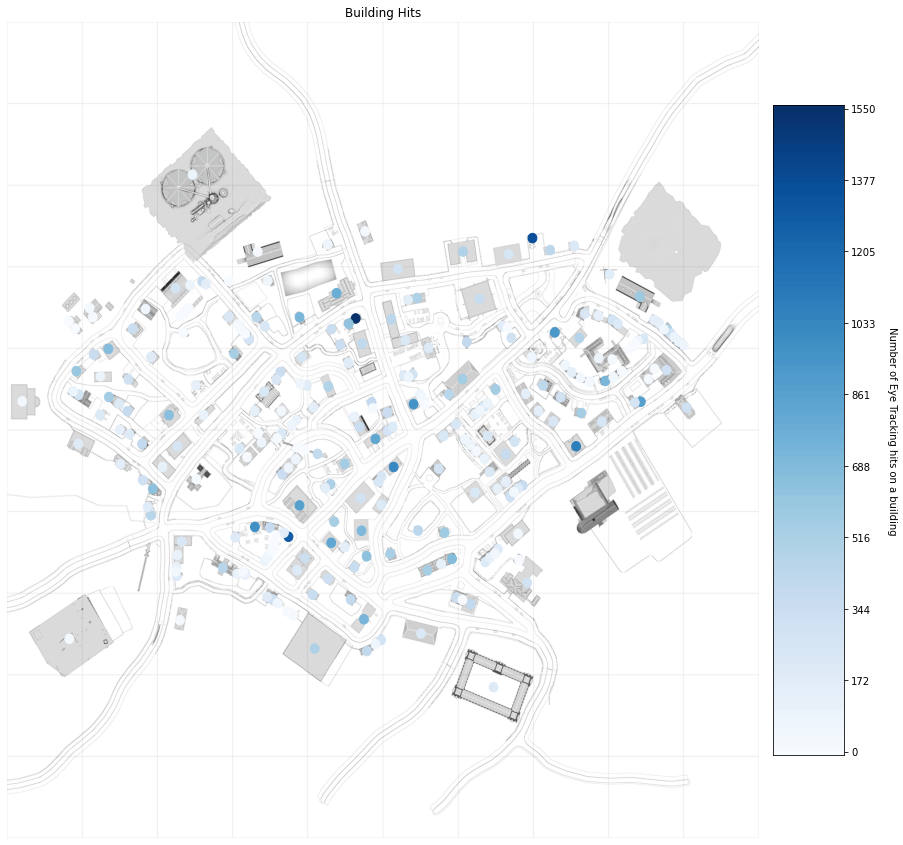

In [22]:
# all buildings

# plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Building Hits")
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

# colormap 
cmap = plt.cm.get_cmap('Blues')

# add circles to map 
min_hits = min(sorted_by_collider["hit_points"])
max_hits = max(sorted_by_collider["hit_points"])
circle_size = 24
circles = [] 
for idx, row in sorted_by_collider.reset_index().iterrows():  
    circles.append(plt.Circle((row["transformed_collidercenter_x"],row["transformed_collidercenter_y"]),circle_size,color = cmap((row["hit_points"] - min_hits) / (max_hits - min_hits)),zorder=2))
    ax.add_artist(circles[idx])  


# color bar on the side 
a=np.outer(np.arange(0,1,0.01),np.ones(3))
ax2 = plt.subplot2grid((10, 10), (1, 9),rowspan=8)
plt.imshow(a,aspect='auto',cmap='Blues',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.linspace(min_hits // 10 * 10,max_hits // 10 * 10,10,dtype=int))
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of Eye Tracking hits on a building",rotation=270,labelpad = 20) # fontsize
ax2.yaxis.set_label_position("right")
plt.show()

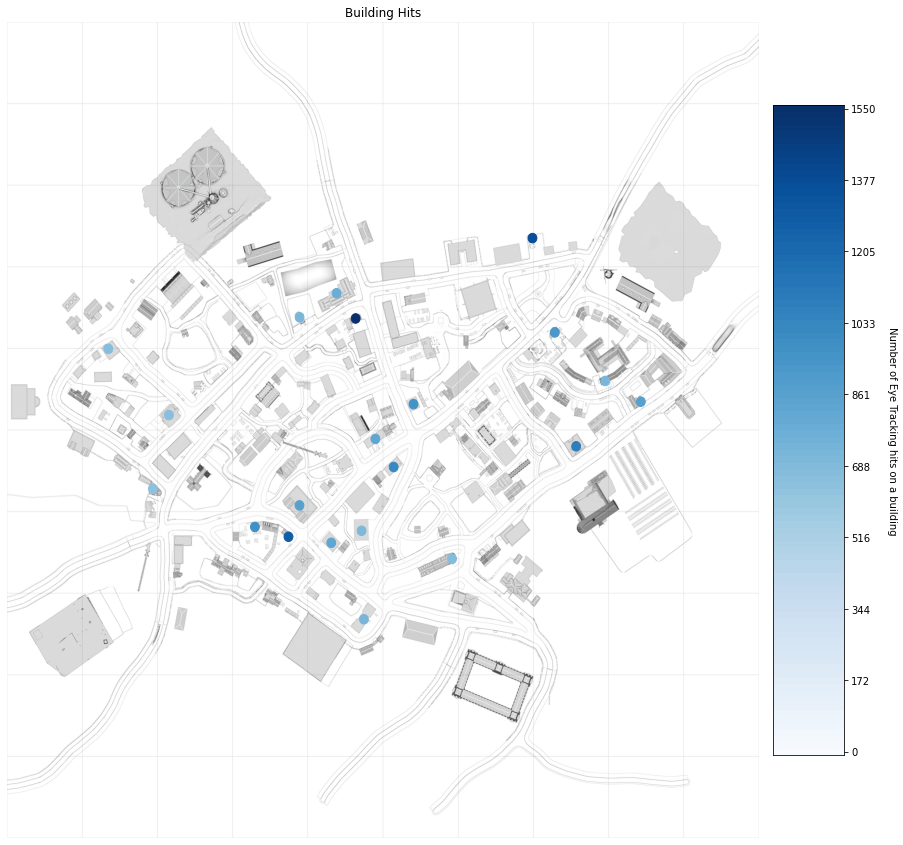

In [23]:
# only top 20 buildings

# plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Building Hits", fontsize = 20)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

# colormap 
cmap = plt.cm.get_cmap('Blues')

# add circles to map 
min_hits = min(sorted_by_collider["hit_points"])
max_hits = max(sorted_by_collider["hit_points"])
circle_size = 24
circles = [] 
for idx, row in sorted_by_collider.reset_index().iterrows():  
    circles.append(plt.Circle((row["transformed_collidercenter_x"],row["transformed_collidercenter_y"]),circle_size,color = cmap((row["hit_points"] - min_hits) / (max_hits - min_hits)),zorder=2))
    ax.add_artist(circles[idx])  
    if idx >= 20:
        break
plt.title("Building Hits") # fontsize

# color bar on the side 
a=np.outer(np.arange(0,1,0.01),np.ones(3))
ax2 = plt.subplot2grid((10, 10), (1, 9),rowspan=8)
plt.imshow(a,aspect='auto',cmap='Blues',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.linspace(min_hits // 10 * 10,max_hits // 10 * 10,10,dtype=int))
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of Eye Tracking hits on a building",rotation=270,labelpad=20) # fontsize
ax2.yaxis.set_label_position("right")
plt.show()

In [24]:
print(sorted_by_collider[sorted_by_collider["hitObjectColliderName"] == 'Windmill-TaskBuilding_10_1'])



     index       hitObjectColliderName  hitObjectColliderBoundsCenter.x  \
259   1421  Windmill-TaskBuilding_10_1                       299.423767   

     hitObjectColliderBoundsCenter.y  hitObjectColliderBoundsCenter.z  \
259                        12.845507                       190.601501   

     hit_points  transformed_collidercenter_x  transformed_collidercenter_y  
259         176                   3281.333981                     2830.5326  


# Load measurement data - Single Pathfinding

In [25]:
single_pathfinding_df = pd.read_csv("./Results/PRELIMINARY_1008_Single_CompleteHitpoints.csv")

single_pathfinding_df = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),dataframe=single_pathfinding_df,df_x_name="hmdPosition.x",df_y_name="hmdPosition.z",transform_x_name="transformed_hmdposition_x",transform_y_name="transformed_hmdposition_y")
single_pathfinding_df = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),dataframe=single_pathfinding_df,df_x_name="hitPointOnObject.x",df_y_name="hitPointOnObject.z",transform_x_name="transformed_hitpoint_x",transform_y_name="transformed_hitpoint_y")

single_pathfinding_df[:10]

Calculating Perspective Transform for DataFrame...


100%|██████████| 214316/214316 [00:23<00:00, 9176.19it/s] 


Calculating Perspective Transform for DataFrame...


100%|██████████| 214316/214316 [00:23<00:00, 9144.17it/s] 


Unnamed: 0  PathNumber  timeStampDataPointStart  timeStampDataPointEnd  \
0           0         0.0                 0.001488               0.007936   
1           1         0.0                 0.001488               0.007936   
2           2         0.0                 0.007936               0.007936   
3           3         0.0                 0.007936               0.007936   
4           4         0.0                 0.011408               0.014880   
5           5         0.0                 0.020832               0.023808   
6           6         0.0                 0.031744               0.034720   
7           7         0.0                 0.043152               0.046129   
8           8         0.0                 0.046129               0.046129   
9           9         0.0                 0.064976               0.067952   

   hitObjectColliderName  ordinalOfHit  BitMask  hitPointOnObject.x  \
0            StartZoneB0           1.0      3.0         -287.080536   
1  road_base_network.004           2.0      3.0         -287.815186   
2            StartZoneB0           1.0      3.0         -287.080536   
3  road_base_network.004           2.0      3.0         -287.815186   
4  road_base_network.004           1.0      3.0         -287.791351   
5  road_base_network.004           1.0      3.0         -287.804169   
6  road_base_network.004           1.0      3.0         -287.795563   
7  road_base_network.004           1.0      3.0         -287.775726   
8  road_base_network.004           1.0      3.0         -287.775726   
9  road_base_network.004           1.0      3.0         -287.768311   

   hitPointOnObject.y  hitPointOnObject.z  hitObjectColliderBoundsCenter.x  \
0            1.464877         -163.314148                      -287.361938   
1           -0.215470         -166.285797                        39.257874   
2            1.464877         -163.314148                      -287.361938   
3           -0.215470         -166.285797                        39.257874   
4           -0.215331         -166.280533                        39.257874   
5           -0.216395         -166.319504                        39.257874   
6           -0.214109         -166.235962                        39.257874   
7           -0.213908         -166.228439                        39.257874   
8           -0.213908         -166.228439                        39.257874   
9           -0.212512         -166.177429                        39.257874   

   hitObjectColliderBoundsCenter.y  hitObjectColliderBoundsCenter.z  \
0                        -0.083385                       -164.81044   
1                        -4.408301                         51.76886   
2                        -0.083385                       -164.81044   
3                        -4.408301                         51.76886   
4                        -4.408301                         51.76886   
5                        -4.408301                         51.76886   
6                        -4.408301                         51.76886   
7                        -4.408301                         51.76886   
8                        -4.408301                         51.76886   
9                        -4.408301                         51.76886   

   hmdPosition.x  hmdPosition.y        hmdPosition.z  \
0    -286.970154       1.720426   -162.8208770751953   
1            NaN            NaN                  NaN   
2    -286.970154       1.720426   -162.8208770751953   
3            NaN            NaN                  NaN   
4    -286.969421       1.718801  -162.86097717285156   
5    -286.968414       1.717103  -162.90536499023438   
6    -286.969543       1.715533  -162.94297790527344   
7    -286.972778       1.713921    -162.981689453125   
8    -286.972778       1.713921    -162.981689453125   
9    -286.982452       1.710641   -163.0576934814453   

   transformed_hmdposition_x  transformed_hmdposition_y  \
0                 864.909296                1376.182819 

In [26]:
# filter out second order hits 
single_pathfinding_df = single_pathfinding_df.loc[single_pathfinding_df["ordinalOfHit"] == 1]
#single_pathfinding_df["hmdPosition.x"].iloc[0] = np.NaN 
print(single_pathfinding_df)
single_pathfinding_df.isnull().values.any()

        Unnamed: 0  PathNumber  timeStampDataPointStart  \
0                0         0.0                 0.001488   
2                2         0.0                 0.007936   
4                4         0.0                 0.011408   
5                5         0.0                 0.020832   
6                6         0.0                 0.031744   
...            ...         ...                      ...   
214306       19984         9.0               106.910451   
214308       19986         9.0               106.929299   
214310       19988         9.0               106.932771   
214312       19990         9.0               106.951619   
214314       19992         9.0               106.954594   

        timeStampDataPointEnd  hitObjectColliderName  ordinalOfHit  BitMask  \
0                    0.007936            StartZoneB0           1.0      3.0   
2                    0.007936            StartZoneB0           1.0      3.0   
4                    0.014880  road_base_network.004  

False

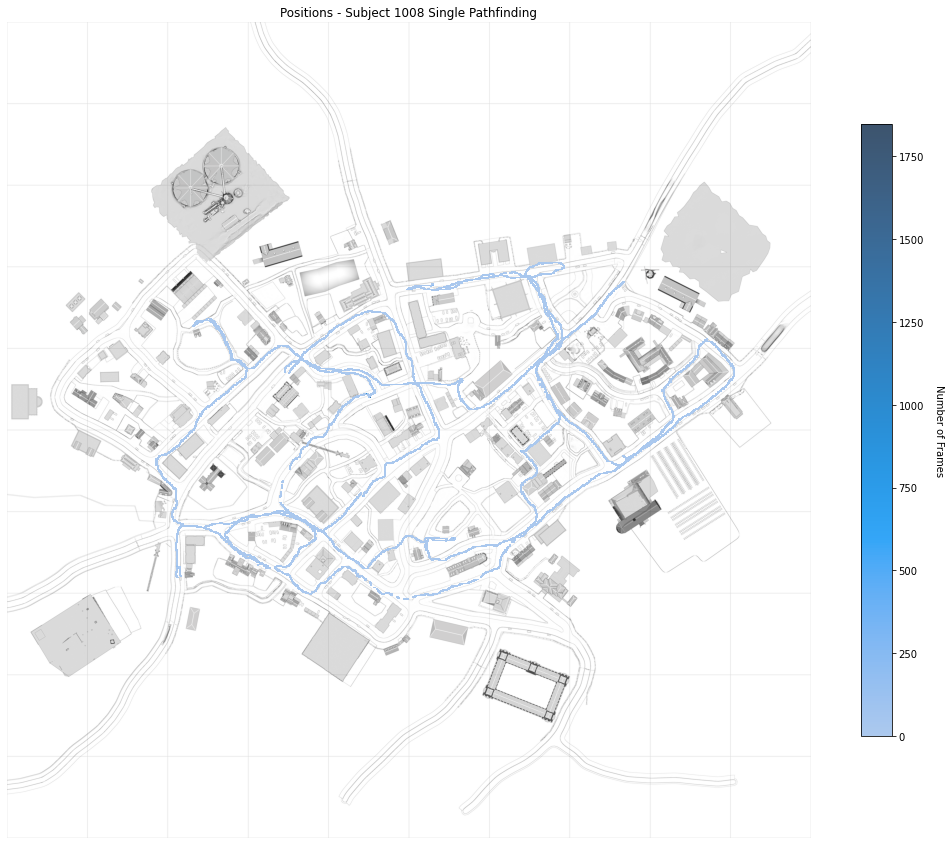

In [27]:
# HMD positions

fig, ax = plt.subplots(figsize=(18, 15))

map_bins = 512 #2048
histplot = sns.histplot(single_pathfinding_df,x="transformed_hmdposition_x",y="transformed_hmdposition_y",bins=map_bins,discrete=(False,False),log_scale=(False,False), cbar=True, cbar_kws=dict(shrink=0.75), alpha = 1, zorder=2, ax=ax)
ax.collections[0].colorbar.set_label("Number of Frames",rotation=270,labelpad=20) # fontsize, labelpad


ax.set_frame_on(False)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
plt.title("Positions - Subject 1008 Single Pathfinding")
plt.axis('off')


# add background map 
histplot.imshow(white_bg_img,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

plt.show() # add




### Trying out

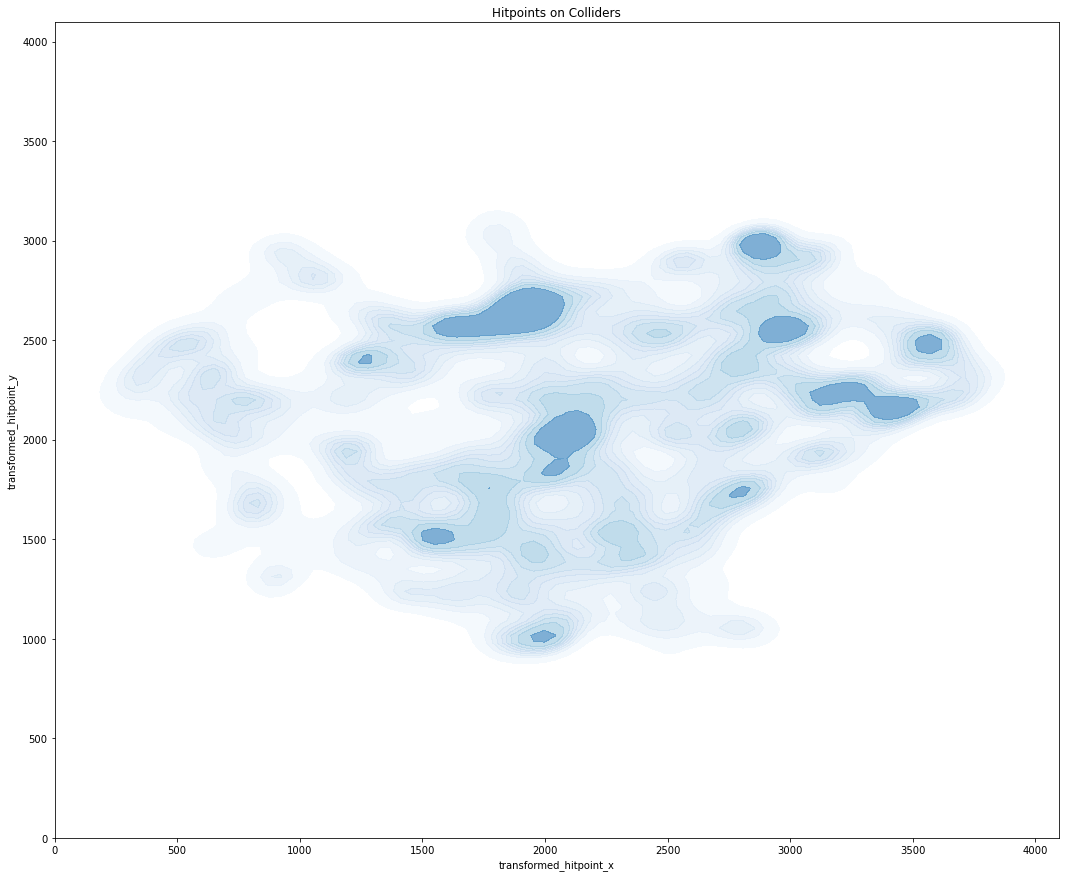

In [49]:

fig, ax = plt.subplots(figsize=(18, 15))

map_bins = 2048
kdeplot = sns.kdeplot(data=only_first_ordinal,x="transformed_hitpoint_x",y="transformed_hitpoint_y", bw= 0.1, cmap="Blues", shade=True, shade_lowest=False, alpha = 0.6, zorder=2, ax=ax)


# plot your KDE
#ax.set_frame_on(False)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
plt.title("Hitpoints on Colliders")
#plt.axis('off')
#plt.show()

# update
histplot.imshow(white_bg_img,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

plt.show() # add





In [67]:
# sns.heatmap(...)
# np.histogram2d(...)